In [42]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_community.tools import GoogleSerperRun
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_community.utilities import GoogleSerperAPIWrapper
import os

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

load_dotenv()
serper_api_key = os.getenv("SERPER_API_KEY")


serper_wrapper = GoogleSerperAPIWrapper(serper_api_key=serper_api_key)


search_tool = GoogleSerperRun(api_wrapper=serper_wrapper)

tools = [search_tool]

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm_with_tools = llm.bind_tools(tools=tools)


In [44]:
# load_dotenv()


# serper_api_key = os.getenv("SERPER_API_KEY")


# search_tool = GoogleSerperRun(api_key=serper_api_key)
# tools = [search_tool]

# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
# llm_with_tools = llm.bind_tools(tools = tools)

In [45]:
def model(state: AgentState):
    return{
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

In [46]:
def tools_router(state: AgentState):
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tool_node"
    else:
        return "end" 

In [47]:
tool_node = ToolNode(tools = tools)

In [48]:


graph = StateGraph(AgentState)
graph.add_node("model", model)
graph.add_node("tool_node", tool_node)
graph.set_entry_point("model")
graph.add_conditional_edges("model", tools_router, {"tool_node": "tool_node", "end": END})
graph.add_edge("tool_node", "model")

In [49]:
app = graph.compile()

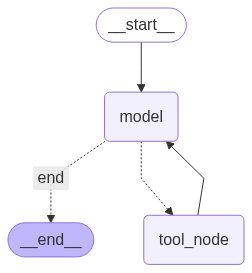

In [50]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method= MermaidDrawMethod.API
        )
    )
)

In [ ]:
# using stream_mode = "values" which will concatenate all the previous messages.
input = {
    "messages": ["Tell me some current news, about US tariffs on EU"]
}

events = app.stream(input = input, stream_mode = "values")

for event in events:
    print(event)

{'messages': [HumanMessage(content='Tell me some current news, about US tariffs on EU', additional_kwargs={}, response_metadata={}, id='a72624f9-2028-495f-b366-5fd0411eb67f')]}
{'messages': [HumanMessage(content='Tell me some current news, about US tariffs on EU', additional_kwargs={}, response_metadata={}, id='a72624f9-2028-495f-b366-5fd0411eb67f'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'google_serper', 'arguments': '{"query": "US tariffs on EU"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--5155e736-93d0-4d66-af6b-e642dfb60993-0', tool_calls=[{'name': 'google_serper', 'args': {'query': 'US tariffs on EU'}, 'id': '8475bd89-fc16-4b81-863b-af4821a5c4f7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 46, 'output_tokens': 9, 'total_tokens': 55, 'input_token_details': {'cache_read': 0}})]}
{'messages': [HumanMessage(content=

In [ ]:
# "Updates" it will give us only what is the new iteam updated in the list.
input = {
    "messages": ["Tell me some current news, about US tariffs on EU"]
}
events = app.stream(input = input, stream_mode = "updates")

for event in events:
    print(event)

{'model': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'google_serper', 'arguments': '{"query": "US tariffs on EU"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--545d1725-a48f-4c05-8d5d-0490df611648-0', tool_calls=[{'name': 'google_serper', 'args': {'query': 'US tariffs on EU'}, 'id': 'a885a635-662d-4004-941b-0b9335b454d4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 46, 'output_tokens': 9, 'total_tokens': 55, 'input_token_details': {'cache_read': 0}})]}}
{'tool_node': {'messages': [ToolMessage(content='A 30% tariff will almost certainly trigger a trade war, even a 15% tariff will be difficult to “eat” (the now widely used term for absorbing ... "The US announcement of 30% tariffs on goods imported from the European Union is concerning and not the way forward. The European Commission can ... President Donald Tru

In [55]:
#streaming 
# no tool calls for now

input = {
    "messages": ["Hi, how are you?"]
}

events = app.astream_events(input = input, version= "v2")

async for event in events:
    print(event)


{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, how are you?']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '0a9942ed-2f1d-4c52-be3d-436494a27d78', 'metadata': {}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='7efa1ac4-4f38-417d-950b-2410fb467d85')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': '8d4398bc-b21f-47a9-b53b-bd76a4f41f78', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:0e9aa503-a01c-a3c2-3200-8c510955a7ad'}, 'parent_ids': ['0a9942ed-2f1d-4c52-be3d-436494a27d78']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='7efa1ac4-4f38-417d-950b-2410fb467d85')]]}}, 'name': 'ChatGoogleGenerativeAI', '

In [58]:
input = {
    "messages": ["Hi, how are you?"]
}

events = app.astream_events(input = input, version = "v2")

async for event in events:
    if event['event'] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="",flush=True)

I'm doing well, thank you for asking! How are you today?
